# Active Subspaces Example Function: Borehole Water Flow

##### Ryan Howard, CO School of Mines, <ryhoward@mines.edu>
##### Paul Constantine, CO School of Mines, <pconstan@mines.edu>

<br>

In this tutorial, we'll be demonstrating active subspaces on the function

$$
f = \frac{2\pi T_u(H_u-H_l)}{\ln (r/r_w)\left(1+\frac{2LT_u}{\ln(r/r_w)r_w^2K_w}+\frac{T_u}{T_l}\right)},
$$

as seen on [http://www.sfu.ca/~ssurjano/borehole.html](http://www.sfu.ca/~ssurjano/borehole.html). This function describes water flow through a borehole, and its inputs and their distributions are described in the table below.

Variable|Symbol|Distribution (U(min, max), N(mu, sigma), or LN(mu, sigma))
:-----|:-----:|:-----
radius of borehole|$r_w$|N(.1, 0.0161812)
radius of influence|$r$|LN(7.71, 1.0056)
transmissivity of upper aquifer|$T_u$|U(63070, 115600)
potentiometric head of upper aquifer|$H_u$|U(990, 1110)
transmissivity of lower aquifer|$T_l$|U(63.1, 116)
potentiometric head of lower aquifer|$H_l$|U(700, 820)
length of borehole|$L$|U(1120, 1680)
hydraulic conductivity of borehole|$K_w$|U(9855, 12045)

In [1]:
import active_subspaces
import numpy as np
%matplotlib inline

# The borehole_functions.py file contains two functions: the borehole function (borehole(xx))
# and its gradient (borehole_grad(xx)). Each takes an Mx8 matrix (M is the number of data
# points) with rows being normalized inputs; borehole returns a column vector of function
# values at each row of the input and borehole_grad returns a matrix whose ith row is the
# gradient of borehole at the ith row of x with respect to the normalized inputs
from borehole_functions import *

First we draw M samples randomly from the input space.

In [2]:
M = 1000 #This is the number of data points to use

#Sample the input space according to the distributions in the table above
rw = np.random.normal(.1, .0161812, (M, 1))
r = np.exp(np.random.normal(7.71, 1.0056, (M, 1)))
Tu = np.random.uniform(63070, 115600, (M, 1))
Hu = np.random.uniform(990, 1110, (M, 1))
Tl = np.random.uniform(63.1, 116, (M, 1))
Hl = np.random.uniform(700, 820, (M, 1))
L = np.random.uniform(1120, 1680, (M, 1))
Kw = np.random.uniform(9855, 12045, (M, 1))

#the input matrix
x = np.hstack((rw, r, Tu, Hu, Tl, Hl, L, Kw))

Now we normalize the sampled values of the input parameters. The uniform inputs are linearly scaled to the interval $[-1, 1]$, normal inputs are scaled like $\frac{x-\mu}{\sigma}$, and logs of lognormal inputs are scaled like normal inputs.

In [3]:
#Upper and lower limits for uniform-bounded inputs
xl = np.array([63070, 990, 63.1, 700, 1120, 9855])
xu = np.array([115600, 1110, 116, 820, 1680, 12045])

#XX = normalized input matrix
XX = ac.utils.misc.BoundedNormalizer(xl, xu).normalize(x[:, 2:])

#normalize non-uniform inputs
rw_norm = ((rw - .1)/.0161812).reshape(M, 1)
r_norm = np.log(r); r_norm = ((r_norm - 7.71)/1.0056).reshape(M, 1)

XX = np.hstack((rw_norm, r_norm, XX))

Compute gradients at the normalized input values to approximate the matrix on which the active subspace is based.

In [4]:
#output values (f) and gradients (df)
f = borehole(XX)
df = borehole_grad(XX)

Now we use our gradient samples to compute the active subspace.

In [5]:
#Set up our subspace using the gradient samples
ss = ac.subspaces.Subspaces()
ss.compute(df=df, nboot=500)

n should be an integer. Performing conversion.


We use plotting utilities to plot eigenvalues, subspace error, components for the first two eigenvectors, and 1D and 2D sufficient summary plots (plots of function values vs. active variable values).

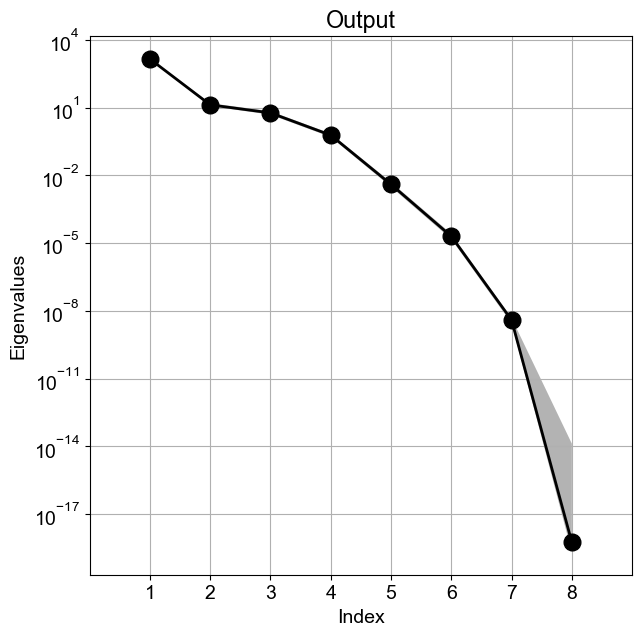

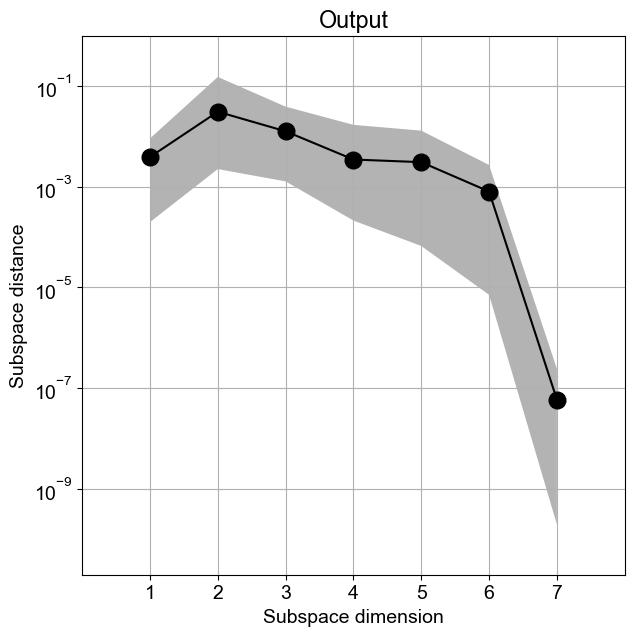

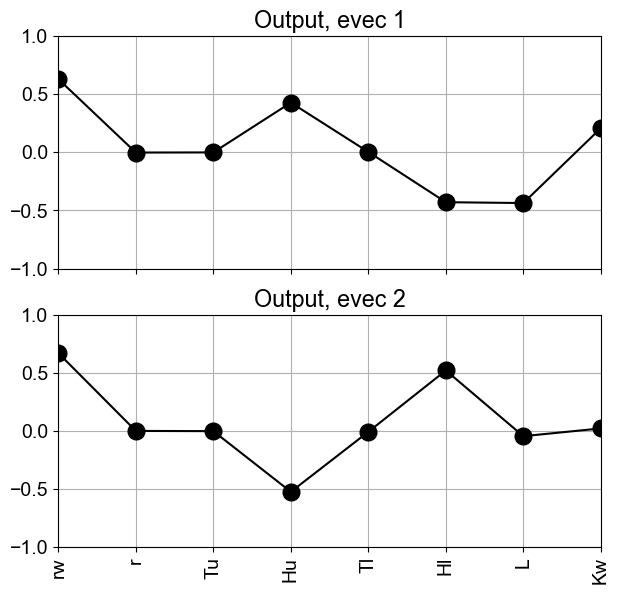

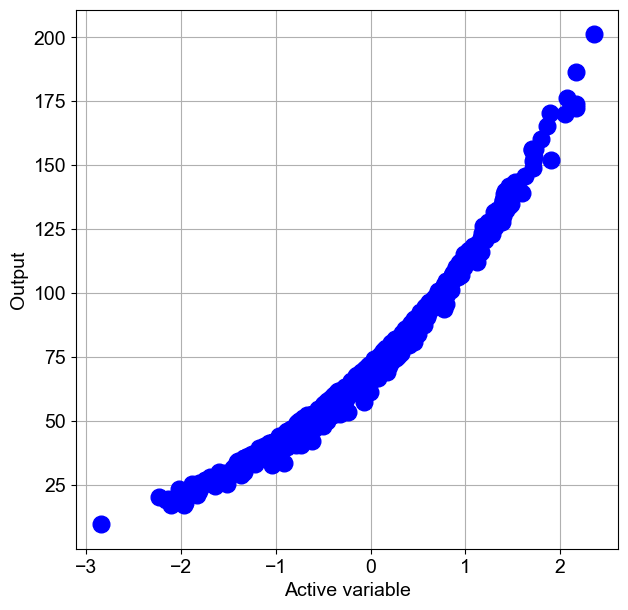

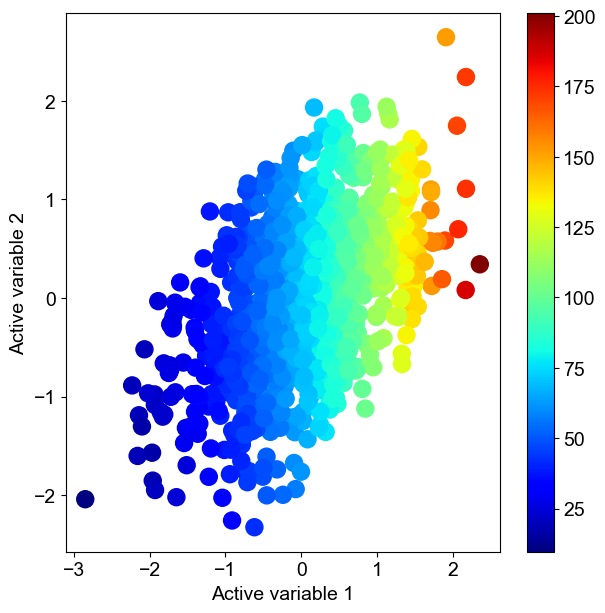

In [6]:
#Component labels
in_labels = ['rw', 'r', 'Tu', 'Hu', 'Tl', 'Hl', 'L', 'Kw']

#plot eigenvalues, subspace errors
ac.utils.plotters.eigenvalues(ss.eigenvals, ss.e_br)
ac.utils.plotters.subspace_errors(ss.sub_br)

#manually make the subspace 2D for the eigenvector and 2D summary plots
ss.partition(2)
#Compute the active variable values
y = XX.dot(ss.W1)

#Plot eigenvectors, sufficient summaries
ac.utils.plotters.eigenvectors(ss.W1, in_labels=in_labels)
ac.utils.plotters.sufficient_summary(y, f)

The eigenvalue plot shows a large drop between the first and second eigenvalues; this indicates the presence of a 1D active subspace. The large gap in eigenvalues means the subspace error will be low in the 1D case, as shown in the subspace distance plot. The sufficient summary plots do indeed show a tight univariate trend in the active variable, confirming the existence of a 1D active subspace.